In [ ]:

import numpy as np
import random
import sys
import copy
import time

ROWS = 6
COLUMNS = 7

def create_board():
    board = [[None for _ in range(COLUMNS)] for _ in range(ROWS)]
    return board

def print_board(board):
    print('0 1 2 3 4 5 6')
    for row in board:
        print(' '.join(['.' if cell is None else cell for cell in row]))

# Check if the column has space to drop the piece
def is_column_avilable(board, col):
    if (board[0][col] == None):
        return True
    else:
        False

#Return to the next empty row of the designated column
def next_empty_row(board, col):
    for row in range(ROWS-1, -1, -1):
        if board[row][col] == None:
            return row

# Place piece
def drop_piece(board, row, col, piece):
    board[row][col] = str(piece)


def check_win(board, piece):
    """
    Checks if there is a winning set of 4 on the board

    :param board:
        nested list obect representing the current board

    :param piece:
        string representing the character player

    :return:
        boolean representing win status
    """
    # Check horizontal
    for col in range(COLUMNS - 3):
        for row in range(ROWS):
            if all(board[row][col + i] == piece for i in range(4)):
                return True

    # Check vertical
    for col in range(COLUMNS):
        for row in range(ROWS - 3):
            if all(board[row + i][col] == piece for i in range(4)):
                return True

    # Check diagonals with positive slope
    for col in range(COLUMNS - 3):
        for row in range(ROWS - 3):
            if all(board[row + i][col + i] == piece for i in range(4)):
                return True

    # Check diagonals with negative slope
    for col in range(COLUMNS - 3):
        for row in range(3, ROWS):
            if all(board[row - i][col + i] == piece for i in range(4)):
                return True

    return False

def evaluate_window(window, piece):
    """
    Looks at a span of 4 pieces and evaluates the score

    :param window:
        list of 4 adjacent spaces

    :param piece:
        string representing the character player

    :return:
        a score in the form of a float
    """

    if piece == "P":
      opp_piece = "A"
    else:
      opp_piece = "P"

    # evaluate window score based on pieces
    # really only care when windows contain one type of piece otherwise meaningless
    if window.count(piece) + window.count(None) == 4:
        score = 10^(window.count(piece))
    elif window.count(opp_piece) + window.count(None) == 4:
        score = -10^(window.count(opp_piece))
    else:
         score = 0

    return score


def evaluate(board, piece):
    """
    Defines a score for the given player's state on the board. Required when a win is not obtainable
    within the depth of algorithm

    :param board:
        nested list obect representing the current board

    :param piece:
        string representing the character player

    :return:
        a score in the form of a float
    """

    score = 0

    ## Score center column
    # center_array = [_row[COLUMNS//2] for _row in board]
    # center_count = center_array.count(piece)
    # score += center_count * 3

    ## Score Horizontal
    for r in range(ROWS):
      row_array = list(board[r])
      for c in range(COLUMNS-3):
        window = row_array[c:c+4]
        score += evaluate_window(window, piece)

    ## Score Vertical
    for c in range(COLUMNS):
      col_array = [_row[c] for _row in board]
      for r in range(ROWS-3):
        window = col_array[r:r+4]
        score += evaluate_window(window, piece)

    ## Score positive sloped diagonal
    for r in range(ROWS-3):
      for c in range(COLUMNS-3):
        window = [board[r+i][c+i] for i in range(4)]
        score += evaluate_window(window, piece)

    ## Score opposite sloped diagonal
    for r in range(ROWS-3):
      for c in range(COLUMNS-3):
        window = [board[r+3-i][c+i] for i in range(4)]
        score += evaluate_window(window, piece)

    return score


def dumb_column_player():
  """
  randomly selects a column to play in
  normally distributed towards middle columns for better positions

  :return:
     random_value integer of column selected
  """
  # Set the parameters
  mean = 3
  std_dev = 1.5  # Adjust this value to control the spread of the distribution

  # Generate a single random value from the normal distribution
  random_value = np.random.normal(mean, std_dev)

  # Clip the value to the desired range (0-7)
  random_value = np.clip(random_value, 0, 7)

  # Round the value to an integer
  random_value = round(random_value)

  return random_value



def min_max_algorithm(board, depth, alpha, beta, maximize):
    """
    Recursive Algorithm to identify the best possible scoring move

    :param board:
        nested list obect representing the current board

    :param depth:
        integer representing how deep into decision tree algorithm is evaluating

    :param alpha:
        float representing minimum score that the maximizing player is assured of

    :param beta:
        float representing maximum score that the minimizing player is assured of

    :param maximize:
        boolean to identify if player is maximizing or minimizing
        maximize on AI
        minimize on player

    :return:
        tuple (best column, score in the form of a float)
    """
    #find the avilable columns
    available_columns = []
    for column in range(COLUMNS):
        if is_column_avilable(board, column):
            available_columns.append(column)

    #If the Ai wins, give high scores
    if check_win(board, 'A'):
        return (None, float(100000))
    #If the player wins, give low scores
    elif check_win(board, 'P'):
        return (None, float(-100000))
    #If there is no available columns, the game is over
    elif (len(available_columns) == 0):
        return (None, 0)
    #if the depth reaches 0, compute the score
    elif depth == 0:
        return (None, evaluate(board, 'A'))


    #If it's AI's turn, take the maximum score
    if maximize:
        max_value = -float('inf')
        best_col = 0
        for col in available_columns:
            copied_board = copy.deepcopy(board)
            drop_piece(copied_board, next_empty_row(copied_board, col), col, "A")
            _, eval_score = min_max_algorithm(copied_board, depth-1, alpha, beta, False)
            if eval_score > max_value:
                best_col = col
                max_value = eval_score
            alpha = max(alpha, max_value)
            if beta <= alpha:
                break
        return best_col, max_value

    #If it's user's turn, take the minimum score
    else:
        min_value = float('inf')
        best_col = 0
        for col in available_columns:
            copied_board = copy.deepcopy(board)
            drop_piece(copied_board, next_empty_row(copied_board, col), col, "P")
            _, eval_score = min_max_algorithm(copied_board, depth-1, alpha, beta, True)
            if eval_score < min_value:
                best_col = col
                min_value = eval_score
            beta = min(beta, min_value)
            if beta <= alpha:
                break

        return best_col, min_value

def play_game(AI_first=False,
              AI_vs_AI=False,
              AI_depth=3,
              random_player=False,
              print_boards=True,
              ):
    """
    function to start game play

    :param AI_first:
        boolean to determine if AI or player goes first

    :return:
        None
    """
    # initialize game settings
    board = create_board()
    print_board(board)
    game_over = False
    turn_times = []
    winner = None
    if AI_first:
      turn = 1
    else:
      turn = 0

    # go through turns
    while not game_over:
        if turn == 0:  # Player's turn
            try:
                if random_player:
                    col = dumb_column_player()
                elif AI_vs_AI:
                    if len(turn_times) == 0:
                        col = dumb_column_player()
                    else:
                        col, score = min_max_algorithm(board, 1, -np.inf, np.inf, False)
                else:
                    col = int(input("Player, choose a column (0-6): "))
                # check column is valid
                if not 0 <= col <= 6:
                    raise ValueError("Column is out of the designated range.")
                if not is_column_avilable(board, col):
                    raise ValueError("Column is full. Try a different column.")
            except ValueError as e:
                print(e)
                continue

            row = next_empty_row(board, col)
            drop_piece(board, row, col, 'P')
            if check_win(board, 'P'):
                print_board(board)
                print("Player wins!")
                winner = 'P'
                break

        else:  # AI's turn
            start = time.time()
            col, score = min_max_algorithm(board, AI_depth, -np.inf, np.inf, True)
            print(f"best ai column: {col}")
            print(f"score: {score}")
            row = next_empty_row(board, col)
            drop_piece(board, row, col, 'A')

            end = time.time()
            turn_times.append(end - start)

            if check_win(board, 'A'):
                print_board(board)
                print("AI wins!")
                winner = 'AI'
                break

        if print_boards:
            print_board(board)
        turn = (turn + 1) % 2

    return winner, turn_times
    print("Game over!")


In [ ]:
play_game()


0 1 2 3 4 5 6
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
Player, choose a column (0-6): 3
0 1 2 3 4 5 6
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . P . . .
best ai column: 2
score: 456
0 1 2 3 4 5 6
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . A P . . .
Player, choose a column (0-6): 3
0 1 2 3 4 5 6
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . P . . .
. . A P . . .
best ai column: 2
score: 308
0 1 2 3 4 5 6
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . A P . . .
. . A P . . .
Player, choose a column (0-6): 3
0 1 2 3 4 5 6
. . . . . . .
. . . . . . .
. . . . . . .
. . . P . . .
. . A P . . .
. . A P . . .
best ai column: 3
score: 186
0 1 2 3 4 5 6
. . . . . . .
. . . . . . .
. . . A . . .
. . . P . . .
. . A P . . .
. . A P . . .
Player, choose a column (0-6): 4
0 1 2 3 4 5 6
. . . . . . .
. . . . . . .
. . . A . . .
. . . P . . .
. . A P . . .
. . A P P .

('P',
 [0.08028125762939453,
  0.10594391822814941,
  0.043868064880371094,
  0.04262042045593262,
  0.052793025970458984,
  0.05225515365600586])

# Test Code below for Best Search Depth:

In [ ]:
# evaluate ai by playing multiple games
import pandas as pd

final_results = pd.DataFrame()


for run_type in ["rand_column", "bad_AI"]:

    for depth in [1, 3, 5]:

        average_turn_time = []
        turns_to_win = []
        total_time = []
        winners = []

        for i in range(20):
            if run_type == "rand_column":
                winner, turn_times = play_game(AI_depth=depth, random_player=True, print_boards=False)
            else:
                winner, turn_times = play_game(AI_depth=depth, AI_vs_AI=True, print_boards=False)

            winners.append(winner)
            average_turn_time.append(np.mean(turn_times))
            turns_to_win.append(len(turn_times))
            total_time.append(np.sum(turn_times))

        temp_results = pd.DataFrame(
            {
                "winner": winners,
                "turns_to_win": turns_to_win,
                "average_turn_time": average_turn_time,
                "total_turn_time": total_time,
            }
            )
        temp_results["depth"] = depth
        temp_results["opponent"] = run_type

        final_results = pd.concat([final_results, temp_results])


best ai column: 3
score: 637
best ai column: 5
score: 621
best ai column: 3
score: 483
best ai column: 5
score: 412
best ai column: 0
score: 383
best ai column: 6
score: 369
best ai column: 4
score: 366
best ai column: 1
score: 356
best ai column: 4
score: 292
best ai column: 2
score: 240
Column is out of the designated range.
best ai column: 2
score: 202
best ai column: 0
score: 158
best ai column: 1
score: 100000.0
0 1 2 3 4 5 6
. . . . . P .
. . . . P P .
A . . . A A .
P A A A P P .
A A A P A A A
P P P A P P P
AI wins!
best ai column: 3
score: 626
best ai column: 3
score: 599
best ai column: 3
score: 390
best ai column: 2
score: 254
best ai column: 4
score: 225
best ai column: 4
score: 126
best ai column: 4
score: 139
best ai column: 5
score: 130
Column is full. Try a different column.
best ai column: 6
score: 100000.0
0 1 2 3 4 5 6
. . . P P . .
. . . P A . .
. . . A A . .
. . P P A . .
. . A A P A .
. . P A P P A
AI wins!
best ai column: 3
score: 626
best ai column: 4
score: 496
b

In [ ]:
final_results["winner"] = np.where(final_results["winner"] == "AI",
                                   1,
                                   0)



In [ ]:
win_rate = final_results.groupby(["depth", "opponent"])["winner"].mean()

summarized_results = final_results.query("winner == 1").groupby(["depth", "opponent"], as_index=False).mean()

summarized_results["winner"] = win_rate.tolist()

print(summarized_results)


   depth     opponent  winner  turns_to_win  average_turn_time  \
0      1       bad_AI    0.20     11.500000           0.004399   
1      1  rand_column    0.95      9.421053           0.002896   
2      3       bad_AI    1.00      5.850000           0.053038   
3      3  rand_column    0.80      7.437500           0.042661   
4      5       bad_AI    1.00     11.400000           0.513101   
5      5  rand_column    1.00      8.300000           0.628071   

   total_turn_time  
0         0.048074  
1         0.027625  
2         0.309894  
3         0.317609  
4         5.392525  
5         5.129450  


In [ ]:

from google.colab import files
summarized_results.to_csv('algorithm_test_results.csv', encoding = 'utf-8-sig')
files.download('algorithm_test_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Print Results

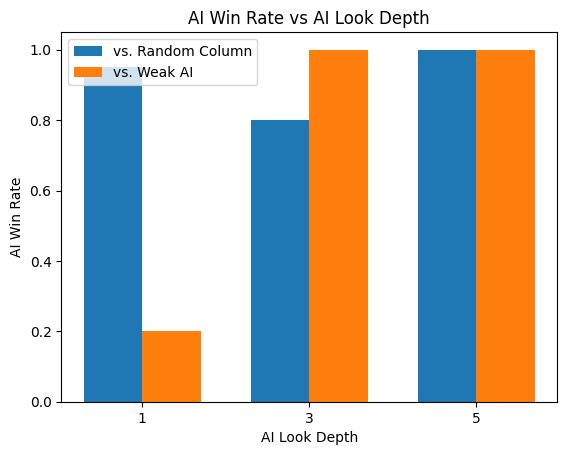

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

summarized_results["opponent"] = np.where(summarized_results["opponent"] == "rand_column",
                                   "vs. Random Column",
                                   "vs. Weak AI")

# Set the bar width and positions
bar_width = 0.35
bar_positions = np.arange(3)
i = 0
# Create a bar plot for each category
for category, group in summarized_results.groupby('opponent'):
    # Plot a bar chart
    # Create grouped bar chart
    plt.bar(bar_positions + i*bar_width, group["winner"], width=bar_width, label=f'{category}', align='center')
    i += 1

# Adjust x-axis ticks and labels
plt.xticks([p+(0.5*bar_width) for p in bar_positions], group["depth"])


# Add legend
plt.legend()

# Add labels and title
plt.xlabel('AI Look Depth')
plt.ylabel('AI Win Rate')
plt.title('AI Win Rate vs AI Look Depth')

# Display the chart
plt.show()


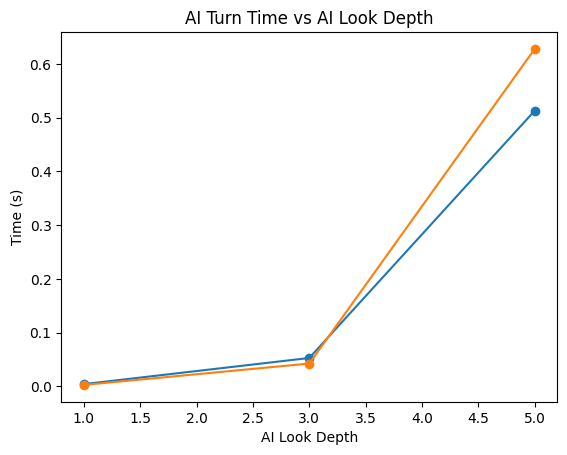

In [ ]:
filtered_df = summarized_results[['average_turn_time']]


# Create a line plot for each category
for category, group in summarized_results.groupby('opponent'):
    # Create a line plot
    plt.plot(group['depth'], group['average_turn_time'], label=f'{category}', marker='o', linestyle='-')


# Add labels and title
plt.xlabel('AI Look Depth')
plt.ylabel('Time (s)')
plt.title('AI Turn Time vs AI Look Depth')

# Display the chart
plt.show()